# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = pretrain_test_dataset.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 140
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})


## label balance

<Axes: ylabel='count'>

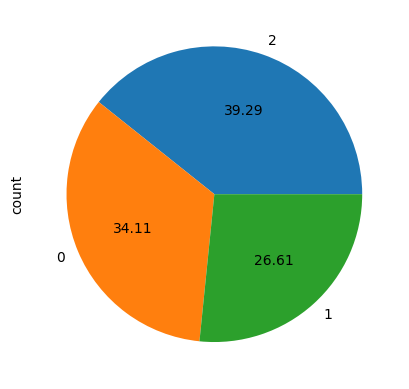

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

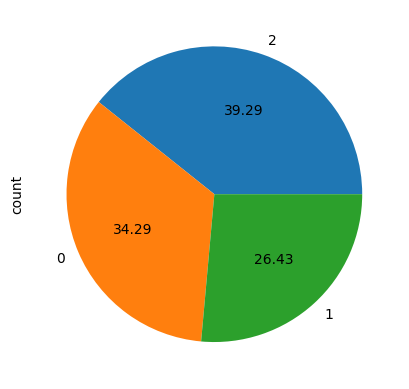

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

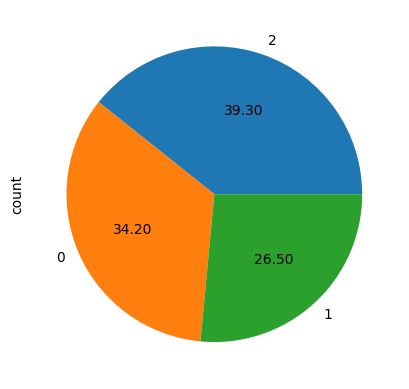

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

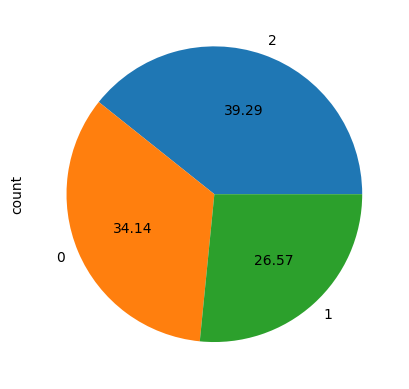

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="lxyuan/distilbert-base-multilingual-cased-sentiments-student"



label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

DistilBertConfig {
  "_name_or_path": "lxyuan/distilbert-base-multilingual-cased-sentiments-student",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "vocab_size": 119547
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [41]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [42]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [43]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [44]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-06 10:15:08,572] A new study created in memory with name: no-name-253b3c35-dd15-4584-94f5-fdc05e83057c
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 43.0694, 'train_samples_per_second': 65.011, 'train_steps_per_second': 1.045, 'train_loss': 1.1337165832519531, 'epoch': 5.0}


[I 2023-12-06 10:16:11,410] Trial 0 finished with value: 1.881509335121867 and parameters: {'learning_rate': 1.4864920120361571e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 1.881509335121867.


{'eval_loss': 1.0225940942764282, 'eval_accuracy': 0.5214285714285715, 'eval_f1': 0.4310308427955487, 'eval_precision': 0.4533298826777088, 'eval_recall': 0.4757200382200382, 'eval_runtime': 0.4651, 'eval_samples_per_second': 300.978, 'eval_steps_per_second': 38.697, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 19.1723, 'train_samples_per_second': 29.209, 'train_steps_per_second': 0.417, 'train_loss': 1.2093253135681152, 'epoch': 1.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 10:16:32,564] Trial 1 finished with value: 1.7074855871317194 and parameters: {'learning_rate': 7.226287038933695e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 72}. Best is trial 0 with value: 1.881509335121867.


{'eval_loss': 1.0537582635879517, 'eval_accuracy': 0.5142857142857142, 'eval_f1': 0.39130037883974617, 'eval_precision': 0.3399045445113094, 'eval_recall': 0.4619949494949495, 'eval_runtime': 0.4581, 'eval_samples_per_second': 305.618, 'eval_steps_per_second': 39.294, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 13.1767, 'train_samples_per_second': 42.499, 'train_steps_per_second': 1.214, 'train_loss': 1.633358120918274, 'epoch': 1.0}


[I 2023-12-06 10:16:47,794] Trial 2 finished with value: 0.8834087958301795 and parameters: {'learning_rate': 3.873434568654232e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 36}. Best is trial 0 with value: 1.881509335121867.


{'eval_loss': 1.5504037141799927, 'eval_accuracy': 0.2, 'eval_f1': 0.21320037986704654, 'eval_precision': 0.2710342417889588, 'eval_recall': 0.19917417417417416, 'eval_runtime': 0.4328, 'eval_samples_per_second': 323.442, 'eval_steps_per_second': 41.585, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 18.4534, 'train_samples_per_second': 60.693, 'train_steps_per_second': 1.734, 'train_loss': 1.4272980690002441, 'epoch': 2.0}


[I 2023-12-06 10:17:08,314] Trial 3 finished with value: 0.9592928166372129 and parameters: {'learning_rate': 5.554231498245852e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 0 with value: 1.881509335121867.


{'eval_loss': 1.2588951587677002, 'eval_accuracy': 0.22857142857142856, 'eval_f1': 0.22922986710705032, 'eval_precision': 0.281907163874377, 'eval_recall': 0.21958435708435708, 'eval_runtime': 0.4239, 'eval_samples_per_second': 330.302, 'eval_steps_per_second': 42.467, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 31.0438, 'train_samples_per_second': 90.195, 'train_steps_per_second': 1.933, 'train_loss': 0.8961500803629557, 'epoch': 5.0}


[I 2023-12-06 10:17:41,623] Trial 4 finished with value: 2.218190517676045 and parameters: {'learning_rate': 4.256022115975804e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 48}. Best is trial 4 with value: 2.218190517676045.


{'eval_loss': 0.9931681156158447, 'eval_accuracy': 0.5785714285714286, 'eval_f1': 0.5450292397660819, 'eval_precision': 0.5447331744818594, 'eval_recall': 0.5498566748566749, 'eval_runtime': 0.4248, 'eval_samples_per_second': 329.539, 'eval_steps_per_second': 42.369, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 33.2365, 'train_samples_per_second': 84.245, 'train_steps_per_second': 3.61, 'train_loss': 0.46875425974527996, 'epoch': 5.0}


[I 2023-12-06 10:18:16,710] Trial 5 finished with value: 2.296826611421552 and parameters: {'learning_rate': 9.867521059147315e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 24}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.7919296026229858, 'eval_accuracy': 0.6, 'eval_f1': 0.5624018887931487, 'eval_precision': 0.5655023912060719, 'eval_recall': 0.5689223314223314, 'eval_runtime': 0.4308, 'eval_samples_per_second': 324.941, 'eval_steps_per_second': 41.778, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 24.6427, 'train_samples_per_second': 90.899, 'train_steps_per_second': 1.623, 'train_loss': 1.166135311126709, 'epoch': 4.0}


[I 2023-12-06 10:18:43,192] Trial 6 finished with value: 1.9094249175771276 and parameters: {'learning_rate': 1.3738592586109104e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 56}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0386945009231567, 'eval_accuracy': 0.5285714285714286, 'eval_f1': 0.4332819930646378, 'eval_precision': 0.46755852842809364, 'eval_recall': 0.48001296751296757, 'eval_runtime': 0.4398, 'eval_samples_per_second': 318.309, 'eval_steps_per_second': 40.925, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 34.8867, 'train_samples_per_second': 80.26, 'train_steps_per_second': 5.016, 'train_loss': 1.458363037109375, 'epoch': 5.0}


[I 2023-12-06 10:19:19,921] Trial 7 finished with value: 0.8877513341250017 and parameters: {'learning_rate': 1.0711133000157772e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.3145338296890259, 'eval_accuracy': 0.20714285714285716, 'eval_f1': 0.21247663062173763, 'eval_precision': 0.26672930745786805, 'eval_recall': 0.2014025389025389, 'eval_runtime': 0.4279, 'eval_samples_per_second': 327.213, 'eval_steps_per_second': 42.07, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 27.9173, 'train_samples_per_second': 80.237, 'train_steps_per_second': 2.579, 'train_loss': 0.7815081808302138, 'epoch': 4.0}


[I 2023-12-06 10:19:49,678] Trial 8 finished with value: 2.000542766023919 and parameters: {'learning_rate': 0.00019148414371817924, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.172698974609375, 'eval_accuracy': 0.5142857142857142, 'eval_f1': 0.48814264189379974, 'eval_precision': 0.5086931704231653, 'eval_recall': 0.48942123942123944, 'eval_runtime': 0.4358, 'eval_samples_per_second': 321.223, 'eval_steps_per_second': 41.3, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 40.6102, 'train_samples_per_second': 68.948, 'train_steps_per_second': 1.108, 'train_loss': 1.55728268093533, 'epoch': 5.0}


[I 2023-12-06 10:20:32,115] Trial 9 finished with value: 0.8162305443684897 and parameters: {'learning_rate': 1.8978293619666403e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.460145115852356, 'eval_accuracy': 0.18571428571428572, 'eval_f1': 0.19551820728291316, 'eval_precision': 0.2517773306505701, 'eval_recall': 0.18322072072072074, 'eval_runtime': 0.4338, 'eval_samples_per_second': 322.696, 'eval_steps_per_second': 41.49, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 23.4001, 'train_samples_per_second': 71.795, 'train_steps_per_second': 3.077, 'train_loss': 1.1240422990587022, 'epoch': 3.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 10:20:57,546] Trial 10 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.0007158731183240666, 'num_train_epochs': 3, 'per_device_train_batch_size': 24}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0864131450653076, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4278, 'eval_samples_per_second': 327.235, 'eval_steps_per_second': 42.073, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 27.4008, 'train_samples_per_second': 81.75, 'train_steps_per_second': 1.752, 'train_loss': 0.8478880723317465, 'epoch': 4.0}


[I 2023-12-06 10:21:26,902] Trial 11 finished with value: 2.1643762816259136 and parameters: {'learning_rate': 6.66838630864484e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 48}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0001544952392578, 'eval_accuracy': 0.5714285714285714, 'eval_f1': 0.5278841433480609, 'eval_precision': 0.5280481423338567, 'eval_recall': 0.5370154245154245, 'eval_runtime': 0.4379, 'eval_samples_per_second': 319.739, 'eval_steps_per_second': 41.109, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 22.8983, 'train_samples_per_second': 73.368, 'train_steps_per_second': 1.572, 'train_loss': 1.0442663828531902, 'epoch': 3.0}


[I 2023-12-06 10:21:51,764] Trial 12 finished with value: 2.2465166099360605 and parameters: {'learning_rate': 4.599569649062267e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 48}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 0.9850940108299255, 'eval_accuracy': 0.5785714285714286, 'eval_f1': 0.5484614118808623, 'eval_precision': 0.5684463684463684, 'eval_recall': 0.5510374010374011, 'eval_runtime': 0.4368, 'eval_samples_per_second': 320.491, 'eval_steps_per_second': 41.206, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 24.4921, 'train_samples_per_second': 68.593, 'train_steps_per_second': 2.94, 'train_loss': 1.083375718858507, 'epoch': 3.0}


[I 2023-12-06 10:22:18,280] Trial 13 finished with value: 1.6098986157948423 and parameters: {'learning_rate': 0.00022369198989225813, 'num_train_epochs': 3, 'per_device_train_batch_size': 24}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0531245470046997, 'eval_accuracy': 0.42857142857142855, 'eval_f1': 0.3403337403337403, 'eval_precision': 0.4422731356693621, 'eval_recall': 0.3987203112203112, 'eval_runtime': 0.4358, 'eval_samples_per_second': 321.223, 'eval_steps_per_second': 41.3, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 17.9801, 'train_samples_per_second': 62.291, 'train_steps_per_second': 1.557, 'train_loss': 1.2100655691964286, 'epoch': 2.0}


[I 2023-12-06 10:22:38,361] Trial 14 finished with value: 1.6783854707608685 and parameters: {'learning_rate': 1.7239276137209655e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 40}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0576926469802856, 'eval_accuracy': 0.45, 'eval_f1': 0.37481189718729485, 'eval_precision': 0.4411111111111112, 'eval_recall': 0.4124624624624625, 'eval_runtime': 0.4388, 'eval_samples_per_second': 319.049, 'eval_steps_per_second': 41.021, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 18.0499, 'train_samples_per_second': 62.05, 'train_steps_per_second': 1.33, 'train_loss': 1.0600544611612956, 'epoch': 2.0}


[I 2023-12-06 10:22:58,273] Trial 15 finished with value: 1.8254811948960883 and parameters: {'learning_rate': 0.00014318613879880706, 'num_train_epochs': 2, 'per_device_train_batch_size': 48}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.004974603652954, 'eval_accuracy': 0.4928571428571429, 'eval_f1': 0.4174213493362429, 'eval_precision': 0.4666666666666666, 'eval_recall': 0.44853603603603603, 'eval_runtime': 0.4358, 'eval_samples_per_second': 321.243, 'eval_steps_per_second': 41.303, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 23.7675, 'train_samples_per_second': 70.685, 'train_steps_per_second': 3.029, 'train_loss': 1.0042054918077257, 'epoch': 3.0}


[I 2023-12-06 10:23:23,920] Trial 16 finished with value: 2.2198507001581014 and parameters: {'learning_rate': 2.9970662748304905e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 24}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 0.9434235692024231, 'eval_accuracy': 0.5857142857142857, 'eval_f1': 0.5350041771094403, 'eval_precision': 0.5494086501107881, 'eval_recall': 0.5497235872235873, 'eval_runtime': 0.4289, 'eval_samples_per_second': 326.451, 'eval_steps_per_second': 41.972, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 25.9185, 'train_samples_per_second': 86.425, 'train_steps_per_second': 2.161, 'train_loss': 1.1217709268842424, 'epoch': 4.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 10:23:51,659] Trial 17 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.00048545905140434713, 'num_train_epochs': 4, 'per_device_train_batch_size': 40}. Best is trial 5 with value: 2.296826611421552.


{'eval_loss': 1.0860109329223633, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4398, 'eval_samples_per_second': 318.309, 'eval_steps_per_second': 40.925, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 18.0405, 'train_samples_per_second': 62.082, 'train_steps_per_second': 3.88, 'train_loss': 0.89774535042899, 'epoch': 2.0}


[I 2023-12-06 10:24:11,633] Trial 18 finished with value: 2.392612995144508 and parameters: {'learning_rate': 9.23847437901798e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 18 with value: 2.392612995144508.


{'eval_loss': 0.9317740201950073, 'eval_accuracy': 0.6214285714285714, 'eval_f1': 0.5867680405495532, 'eval_precision': 0.5925961538461538, 'eval_recall': 0.5918202293202294, 'eval_runtime': 0.4279, 'eval_samples_per_second': 327.208, 'eval_steps_per_second': 42.07, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 20.0051, 'train_samples_per_second': 55.986, 'train_steps_per_second': 3.499, 'train_loss': 0.9240781511579241, 'epoch': 2.0}


[I 2023-12-06 10:24:33,602] Trial 19 finished with value: 2.276756791480509 and parameters: {'learning_rate': 0.00011640750151682769, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 18 with value: 2.392612995144508.


{'eval_loss': 0.8874577283859253, 'eval_accuracy': 0.5928571428571429, 'eval_f1': 0.5597223439158076, 'eval_precision': 0.5586640641943179, 'eval_recall': 0.5655132405132405, 'eval_runtime': 0.4308, 'eval_samples_per_second': 324.942, 'eval_steps_per_second': 41.778, 'epoch': 2.0}


BestRun(run_id='18', objective=2.392612995144508, hyperparameters={'learning_rate': 9.23847437901798e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}, run_summary=None)

# Trainer

In [39]:
training_args = TrainingArguments(
    output_dir='./yresults',          # output directory
    learning_rate=9.23847437901798e-05,
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [40]:
train_out

TrainOutput(global_step=70, training_loss=1.003303963797433, metrics={'train_runtime': 18.3347, 'train_samples_per_second': 61.086, 'train_steps_per_second': 3.818, 'total_flos': 74183066173440.0, 'train_loss': 1.003303963797433, 'epoch': 2.0})

# Confusion matrix

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [52]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [53]:
preds_output.metrics

{'test_loss': 0.9543572068214417,
 'test_accuracy': 0.555,
 'test_f1': 0.4559179432597154,
 'test_precision': 0.5635258035376053,
 'test_recall': 0.5041676317796909,
 'test_runtime': 3.0548,
 'test_samples_per_second': 327.358,
 'test_steps_per_second': 20.624}

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)

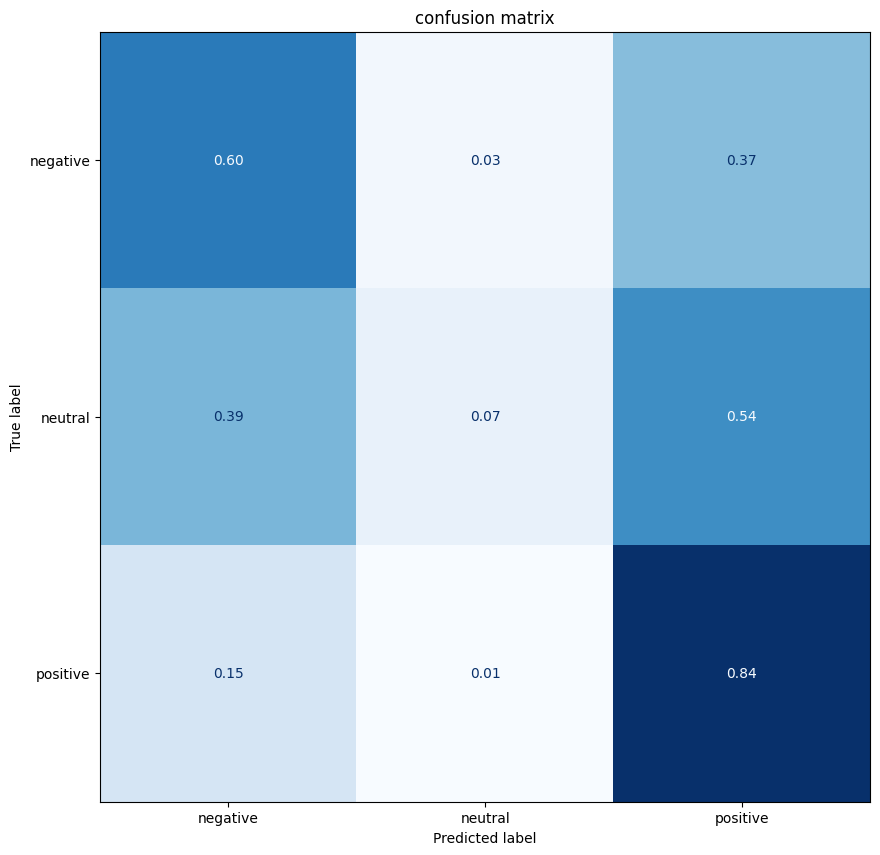

In [55]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [56]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [57]:
preds_output.metrics

{'test_loss': 0.9177355170249939,
 'test_accuracy': 0.5642857142857143,
 'test_f1': 0.45064801903516266,
 'test_precision': 0.46676982021809604,
 'test_recall': 0.5117867867867868,
 'test_runtime': 0.4106,
 'test_samples_per_second': 340.924,
 'test_steps_per_second': 21.917}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

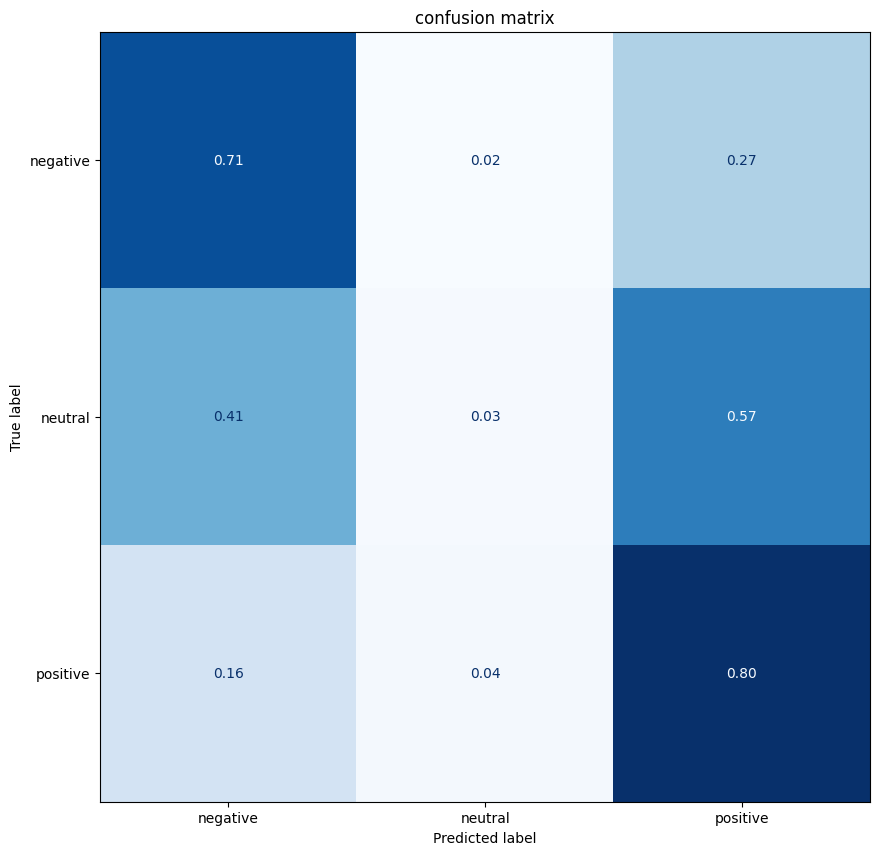

In [59]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [60]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>